## Example of 3D data generation with a constant density model

In this example, we will show how to use PySIT to generate data for a 3D model with a constant density. The corresponding .py file can be found in ``/Demo/GenerateData3DConstantDensity.py``

In [1]:
%matplotlib inline

Import necessary modules:

In [2]:
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import math
import os
from shutil import copy2
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import scipy.io as sio

from pysit import *
from pysit.gallery import horizontal_reflector
from pysit.util.io import *
from pysit.vis.vis import *

from pysit.util.parallel import *

### Define the physical domain, computational mesh and velocity models ###

1. Define perfectly matched layer(PML) boundaries in x, y and z directions with width of ``0.1 km`` and PML coefficient of ``100`` by

    ``pmlx = PML(0.1, 100)`` 
    
    ``pmly = PML(0.1, 100)``

    ``pmlz = PML(0.1, 100)``
    

    For more information about the PML object, we refer users to check ``/pysit/core/domain.py`` by

2. Define a 3D rectangular domain with the ranges of ``(0.1, 1.0) km``, ``(0.1, 0.9) km``, ``(0.1, 0.8) km`` in x, y, and z directions.
    
    ``x_config = (0.1, 1.0, pmlx, pmlx)`` (The physical domain of x direction starts at 0.1 km and ends at 1.0 km.)
    
    ``y_config = (0.1, 0.9, pmly, pmly)`` (The physical domain of y direction starts at 0.1 km and ends at 0.9 km.)
    
    ``z_config = (0.1, 0.8, pmlz, pmlz)`` (The physical domain of z direction starts at 0.1 km and ends at 0.8 km.)
    
    ``d = RectangularDomain(x_config, y_config, z_config)``
    
    For more information about the RectangularDomain, we refer users to check ``/pysit/core/domain.py``.

3. Define the computational Cartesian mesh with ``46`` grids in ``x`` direction, ``41`` grids in ``y`` direction, and ``36`` grids in ``z`` direction by
    
    ``m = CartesianMesh(d, 46, 41, 36)`` (The computational mesh ``m`` meets the physical domain ``d``)
    
    For more information about the CartesianMesh object, we refer users to check ``/pysit/core/mesh.py``.
    
4. Generate the true velocity model and initial model for a Horizontal reflector model by

    ``C, C0, m, d = horizontal_reflector(m)``
    
    The output ``C`` is the true velocity model and ``C0`` is the initial model.
    
    For more information about the horizontal_reflecotr object, we refer users to check ``/pysit/gallery/horizontal_reflector.py``.
    


Text(0.5, 1.0, 'Slice at \n x = 540 m, y = 500 m, z = 440 m')

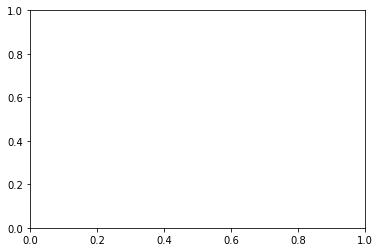

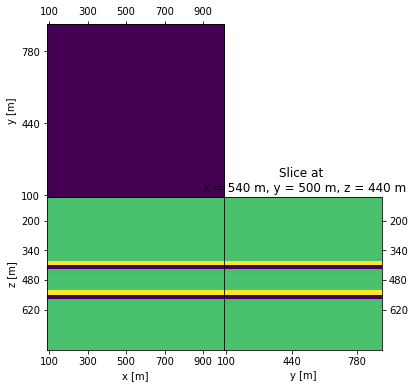

In [3]:
    pmlx = PML(0.1, 100)
    pmly = PML(0.1, 100)
    pmlz = PML(0.1, 100)

    x_config = (0.1, 1.0, pmlx, pmlx)
    y_config = (0.1, 0.9, pmly, pmly)
    z_config = (0.1, 0.8, pmlz, pmlz)

    d = RectangularDomain(x_config, y_config, z_config)

    m = CartesianMesh(d, 46, 41, 36)
    
    C, C0, m, d = horizontal_reflector(m)
    
    n_data = (46, 41, 36)
    n_dataplt = (n_data[0], n_data[2], n_data[1])
    Cplot = np.reshape(C, n_data)
    Cplot = np.transpose(Cplot, (0, 2, 1))
    origins = [0.1, 0.1, 0.1]
    deltas = [0.02, 0.02, 0.02]
    
    axis_ticks = [np.array(list(range(0, n_dataplt[0]-5, (n_data[0]-6)//4))), 
                  np.array(list(range(5, n_dataplt[1]-5, (n_data[1]-11)//4))),
                  np.array(list(range(0, n_dataplt[2], (n_data[2]-1)//2)))
                 ]
    axis_tickslabels = [(axis_ticks[0] * deltas[0] * 1000.0 + origins[0] * 1000.0).astype(int),
                        (axis_ticks[1] * deltas[1] * 1000.0 + origins[1] * 1000.0).astype(int),
                        (axis_ticks[2] * deltas[2] * 1000.0 + origins[2] * 1000.0).astype(int)
                       ]

    
    plot_3D_panel(Cplot, slice3d=(22, 18, 20),
                  axis_label=['x [m]', 'z [m]', 'y [m]'],
                  axis_ticks=axis_ticks,
                  axis_tickslabels=axis_tickslabels,
                 )
    plt.title('Slice at \n x = 540 m, y = 500 m, z = 440 m')
    

### Set up shots
1. Set up the shots object by:

    ``shots = equispaced_acquisition(m, RickerWavelet(10.0), sources=Nshots, source_depth=zpos,source_kwargs={},receivers='max',receiver_depth=zpos,receiver_kwargs={})``

    ``equispaced_acquisition`` - create a shots object with equially spaced acquisition

    ``m`` - computational mesh

    ``RickerWavelet(10.0)`` - a Ricker wavelet centered at ``10 Hz``

    ``sources`` - number of sources, for 3D modeling, sources has two elements that indicates number of sources in x and y directions. For example, ``sources = (2,3)`` means that there are 2 shots in the x direction and 3 shots in the y direction.

    ``source_depth`` - the depth of sources

    ``receivers`` - number of receivers, if set to be ``max``, then the number of receivers equals to the number of grids in x direction.

    ``receiver_depth`` - the depth of receivers
    
    For more information about the ``equispaced_acquisition`` object, we refer the users to check ``/pysit/core/acquisition.py``. 
    
2. Set up the range of recording time by;

    ``trange = (0.0,3.0)``.
    


                                   



In [4]:
# Set up shots
    zmin = d.z.lbound
    zmax = d.z.rbound
    zpos = zmin + (1./9.)*zmax

    Nshots = 1,1

    shots = equispaced_acquisition(m,
                                   RickerWavelet(10.0),
                                   sources=Nshots,
                                   source_depth=zpos,
                                   source_kwargs={},
                                   receivers='max',
                                   receiver_depth=zpos,
                                   receiver_kwargs={}
                                   )
    
    shots_freq = copy.deepcopy(shots)


    # Define and configure the wave solver
    trange = (0.0,3.0)

/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/construct.py:502: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(blocks) != 2:
/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


<class 'numpy.float64'>
1.0


### Define the wave-equation solver and the computational model object, and generate time-domain data 

1. In this example, we use the time-domain constant density acoustic wave as our target wave equation. We set up our wave equation solver by:

    ``solver = ConstantDensityAcousticWave(m, spatial_accuracy_order=2, trange=trange, kernel_implementation='cpp')``
                                     
    ``m`` - the computational mesh

    ``spatial_accuracy_order`` - the spatial accuray order for the numerical solver. Users can select one of the four values ``2, 4, 6, 8``. 

    ``trange`` - the range of the recording time

    ``kernel_implementattion`` - the implementation of the stencil kernel. When set it to be 'cpp', we use the stencil implemented in the language of ``C++``. 
    
    For more information about the ``ConstantDensityAcousticWave`` object, we refer the users to check ``/pysit/solvers/wave_factory.py``
    
2. Create the velocity model object for the wave-quation solver by:

    ``base_model = solver.ModelParameters(m,{'C': C})``
    
    The model object ``base_model`` contains the information of the computational mesh and the velocity model ``C``.
    
3. Generate the time-domain data by:

    ``generate_seismic_data(shots, solver, base_model)``
    
    The generated data are stored in the object ``shots``. In order to check the data of the $i^{\text{th}}$ shot, you may need to use the command:
    
    ``data = shots[i].receivers.data``
    
    For more information about the ``generate_seismic_data`` function, we refer the users to check ``/pysit/modeling/data_modeling.py``.

In [5]:
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=2,
                                         trange=trange,
                                         kernel_implementation='cpp')
    
    base_model = solver.ModelParameters(m,{'C': C})
    
    generate_seismic_data(shots, solver, base_model)
    
    data = shots[0].receivers.data
    
    t_smp = np.linspace(trange[0], trange[1], data.shape[0])
    

/math/home/fangzl/Project/PysitConvert/PysitForPython3/pysit/core/mesh.py:436: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_array = in_array.reshape(sh_grid)[sl]
/math/home/fangzl/Project/PysitConvert/PysitForPython3/pysit/core/mesh.py:526: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_array[sl] = in_array.reshape(sh_in_grid)


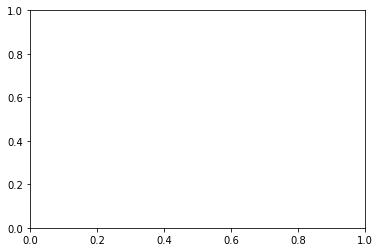

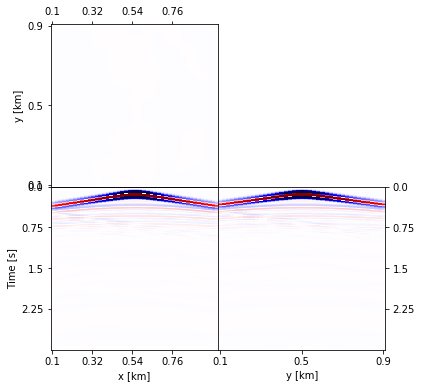

In [6]:
    fig=plt.figure()
    n_recdata = [len(t_smp), n_data[0], n_data[1]]
    n_recdataplt = [n_data[0], len(t_smp), n_data[1]]
    data = np.reshape(data, n_recdata)
    dataplt = np.transpose(data, (1, 0, 2))
    deltas_data = [deltas[0], solver.dt,  deltas[2]]
    origins_data = [origins[0], 0.0,origins[2]]
    
    axis_ticks = [np.array(list(range(0, n_recdataplt[0]-5, (n_recdataplt[0]-1)//4))), 
                  np.array(list(range(0, n_recdataplt[1]-5, (n_recdataplt[1]-1)//4))),
                  np.array(list(range(0, n_recdataplt[2], (n_recdataplt[2]-1)//2)))
                 ]
    axis_tickslabels = [np.round(axis_ticks[0] * deltas_data[0]  + origins_data[0], 2),
                        np.round(axis_ticks[1] * deltas_data[1]  + origins_data[1], 2),
                        np.round(axis_ticks[2] * deltas_data[2]  + origins_data[2], 2)
                       ]

    
    plot_3D_panel(dataplt, slice3d=(22, 900, 20),
                  axis_label=[ 'x [km]', 'Time [s]', 'y [km]'],
                  axis_ticks=axis_ticks,
                  axis_tickslabels=axis_tickslabels,
                  width_ratios=[1,1], height_ratios=[1,1],cmap='seismic', vmin=-0.2,vmax=0.2
                 )

### Generate frequency-domain data

We have shown how to generate the time domain data. Now let us show how to generate the frequency domain data. We only need to change the solver.

In this example, we use the Helmholtz equation with constant density as our target wave equation. In order to generate the frequency domain data, you need to pass values to the parameter ``frequencies`` when using the function of ``generate_seismic_data``. Different from the time domain solver, when generating frequency domain data, the data of $i^{\text{th}}$ shot at frequency of ``f`` is stored in ``shots_freq[i].receivers.data_dft[f]``.

For 3D frequency domain data generation, when set up the PML object, we need to set an additional parameter ``compact`` that indicates we use the compact form of the Helmholtz equation and do not want to get the auxiliary wavefields. As a result, we need to use the following command:

``pmlx = PML(0.1, 100, compact=True)``

``pmly = PML(0.1, 100, compact=True)`` 

``pmlz = PML(0.1, 100, compact=True)``

In [7]:
    pmlx = PML(0.1, 100, compact=True)
    pmly = PML(0.1, 100, compact=True)
    pmlz = PML(0.1, 100, compact=True)

    x_config = (0.1, 1.0, pmlx, pmlx)
    y_config = (0.1, 0.9, pmly, pmly)
    z_config = (0.1, 0.8, pmlz, pmlz)

    d = RectangularDomain(x_config, y_config, z_config)

    m = CartesianMesh(d, 46, 41, 36)
    
    C, C0, m, d = horizontal_reflector(m)
    
    solver = ConstantDensityHelmholtz(m,
                                      spatial_accuracy_order=4)
    
    frequencies = [2.0,3.0]
    
    generate_seismic_data(shots_freq, solver, base_model, frequencies=frequencies)


/math/home/fangzl/.local/lib/python3.6/site-packages/pyamg/gallery/stencil.py:116: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
/math/home/fangzl/.local/lib/python3.6/site-packages/pyamg/gallery/stencil.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/sputils.py:141: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(M) == 0 and

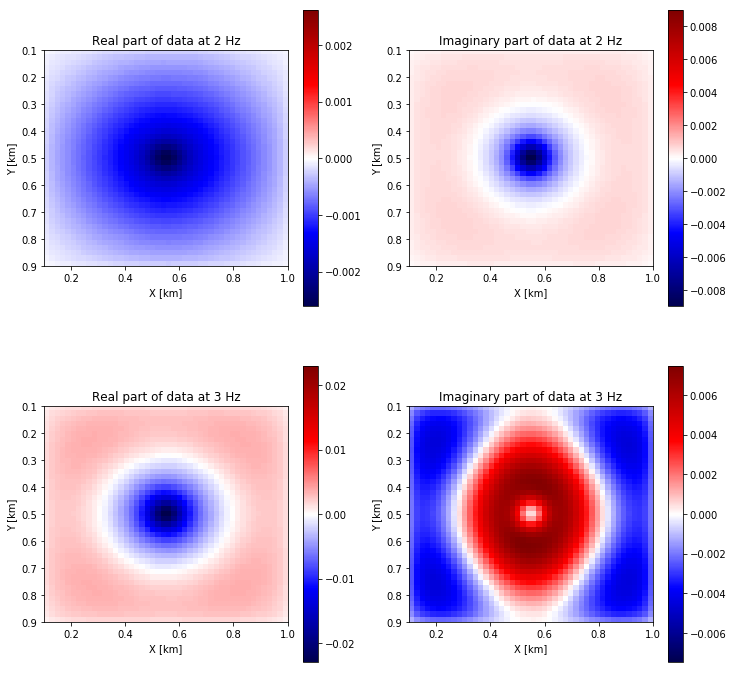

In [34]:
    xrec = np.linspace(0.1,1.0,46)
    yrec = np.linspace(0.1,0.9,41)
    data1 = shots_freq[0].receivers.data_dft[2.0]
    data2 = shots_freq[0].receivers.data_dft[3.0]
    data1 = np.reshape(data1, (len(xrec),len(yrec)))
    data2 = np.reshape(data2, (len(xrec),len(yrec)))
    
    plt.figure(figsize=(12,12))
    plt.subplot(2,2,1)
    vmax = np.abs(np.real(data1)).max()
    clim=np.array([-vmax, vmax])
    plt.imshow(np.real(data1).transpose(),cmap='seismic',clim=clim,
              extent=[xrec[0], xrec[-1], yrec[-1], yrec[0]])
    plt.xlabel('X [km]')
    plt.ylabel('Y [km]')
    plt.title('Real part of data at 2 Hz')
    plt.colorbar()
    
    plt.subplot(2,2,2)
    vmax = np.abs(np.imag(data1)).max()
    clim=np.array([-vmax, vmax])
    plt.imshow(np.imag(data1).transpose(),cmap='seismic',clim=clim,
              extent=[xrec[0], xrec[-1], yrec[-1], yrec[0]])
    plt.xlabel('X [km]')
    plt.ylabel('Y [km]')
    plt.title('Imaginary part of data at 2 Hz')
    plt.colorbar()
    
    plt.subplot(2,2,3)
    vmax = np.abs(np.real(data2)).max()
    clim=np.array([-vmax, vmax])
    plt.imshow(np.real(data2).transpose(),cmap='seismic',clim=clim,
              extent=[xrec[0], xrec[-1], yrec[-1], yrec[0]])
    plt.xlabel('X [km]')
    plt.ylabel('Y [km]')
    plt.title('Real part of data at 3 Hz')
    plt.colorbar()
    
    plt.subplot(2,2,4)
    vmax = np.abs(np.imag(data2)).max()
    clim=np.array([-vmax, vmax])
    plt.imshow(np.imag(data2).transpose(),cmap='seismic',clim=clim,
              extent=[xrec[0], xrec[-1], yrec[-1], yrec[0]])
    plt.xlabel('X [km]')
    plt.ylabel('Y [km]')
    plt.title('Imaginary part of data at 3 Hz')
    plt.colorbar()
    

    

In [27]:
vmax


0.002616404183072598